In [159]:
import pandas as pd
import re

In [123]:
data1 = pd.read_csv('Tweets.csv')

In [124]:
data1

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [125]:
data_baru = data1.drop(columns=['tweet_id','airline_sentiment_confidence','negativereason','negativereason_confidence',
                                'airline','airline_sentiment_gold','name','negativereason_gold','retweet_count',
                                'tweet_coord','tweet_created','tweet_location','user_timezone'])

In [126]:
data_baru.isnull().sum()

airline_sentiment    0
text                 0
dtype: int64

In [167]:
gabung = data_baru.append(data_baru, ignore_index=True)

In [168]:
def hapus_simbol(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

In [170]:
gabung['text_baru'] = np.vectorize(hapus_simbol)(gabung['text'], "@[\w]*")

In [173]:
gabung['text_baru'] = gabung['text_baru'].str.replace("[^a-zA-Z#]", " ")

In [205]:
gabung['text_baru'] = gabung['text_baru'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [206]:
new_text = gabung.drop(columns='text')
new_text.head()

,airline_sentiment,text_baru
0,neutral,What said
1,positive,plus added commercials experience tacky
2,neutral,didn today Must mean need take another trip
3,negative,really aggressive blast obnoxious entertainmen...
4,negative,really thing about


In [207]:
sentiment = pd.get_dummies(new_text.airline_sentiment)
df_baru = pd.concat([new_text, sentiment], axis=1)
df_baru = df_baru.drop(columns='airline_sentiment')
df_baru

,text_baru,negative,neutral,positive
0,What said,0,1,0
1,plus added commercials experience tacky,0,0,1
2,didn today Must mean need take another trip,0,1,0
3,really aggressive blast obnoxious entertainmen...,1,0,0
4,really thing about,1,0,0
...,...,...,...,...
29275,thank different flight Chicago,0,0,1
29276,leaving over minutes Late Flight warnings comm...,1,0,0
29277,Please bring American Airlines #BlackBerry,0,1,0
29278,have money change flight answer your phones ot...,1,0,0


In [208]:
comment = df_baru['text_baru'].values
label = df_baru[['negative', 'neutral', 'positive']].values

In [209]:
print(df_baru)

                                               text_baru  ...  positive
0                                              What said  ...         0
1                plus added commercials experience tacky  ...         1
2            didn today Must mean need take another trip  ...         0
3      really aggressive blast obnoxious entertainmen...  ...         0
4                                     really thing about  ...         0
...                                                  ...  ...       ...
29275                     thank different flight Chicago  ...         1
29276  leaving over minutes Late Flight warnings comm...  ...         0
29277         Please bring American Airlines #BlackBerry  ...         0
29278  have money change flight answer your phones ot...  ...         0
29279  have need know many seats next flight standby ...  ...         0

[29280 rows x 4 columns]


In [210]:
from sklearn.model_selection import train_test_split
data_latih, data_test, label_latih, label_test = train_test_split(comment, label, test_size=0.2)

In [211]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=10000, oov_token='flight')
tokenizer.fit_on_texts(data_latih)
 
sekuens_latih = tokenizer.texts_to_sequences(data_latih)
sekuens_test = tokenizer.texts_to_sequences(data_test)
 
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

In [212]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [213]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92) :
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [214]:
num_epochs = 20
history = model.fit(padded_latih, label_latih, epochs=num_epochs, batch_size=128, callbacks=[callbacks],
                    validation_data=(padded_test, label_test), verbose=2)

Epoch 1/20
183/183 - 4s - loss: 0.7421 - accuracy: 0.6891 - val_loss: 0.5656 - val_accuracy: 0.7650
Epoch 2/20
183/183 - 4s - loss: 0.4749 - accuracy: 0.8143 - val_loss: 0.4818 - val_accuracy: 0.8214
Epoch 3/20
183/183 - 4s - loss: 0.3628 - accuracy: 0.8693 - val_loss: 0.3952 - val_accuracy: 0.8588
Epoch 4/20
183/183 - 4s - loss: 0.2689 - accuracy: 0.9083 - val_loss: 0.3569 - val_accuracy: 0.8818
Epoch 5/20
183/183 - 4s - loss: 0.2176 - accuracy: 0.9290 - val_loss: 0.3512 - val_accuracy: 0.8878
Epoch 6/20
183/183 - 4s - loss: 0.1865 - accuracy: 0.9416 - val_loss: 0.3223 - val_accuracy: 0.9008
Epoch 7/20
183/183 - 4s - loss: 0.1580 - accuracy: 0.9498 - val_loss: 0.3395 - val_accuracy: 0.9085
Epoch 8/20
183/183 - 4s - loss: 0.1395 - accuracy: 0.9565 - val_loss: 0.3366 - val_accuracy: 0.9126
Epoch 9/20
183/183 - 4s - loss: 0.1274 - accuracy: 0.9617 - val_loss: 0.3395 - val_accuracy: 0.9150
Epoch 10/20
183/183 - 4s - loss: 0.1206 - accuracy: 0.9615 - val_loss: 0.3247 - val_accuracy: 0.9172

In [215]:
import matplotlib.pyplot as plt

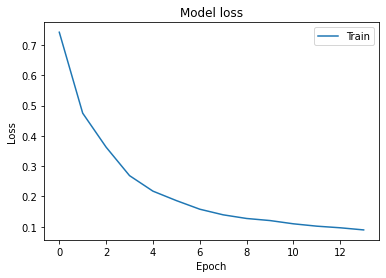

In [216]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

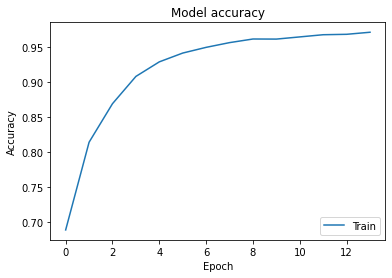

In [217]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

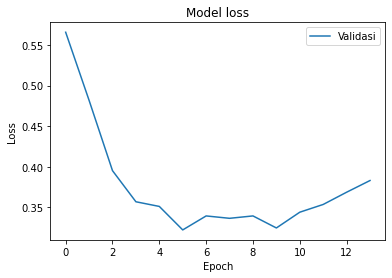

In [222]:
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validasi'], loc='upper right')
plt.show()

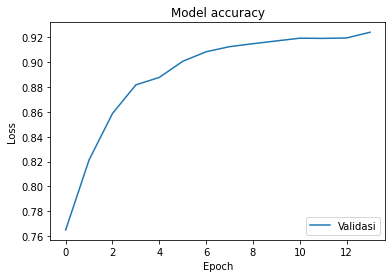

In [224]:
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validasi'], loc='lower right')
plt.show()